# Recommendations with IBM

In this notebook, we will see different examples of implementations of recommendation engines, that will be using  real data from the IBM Watson Studio platform. 

Different methods for making recommendations that can be used for different situations will be shown and commented in the following sections.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (OPTIONAL)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>


Each section will have specific questions to be answered, either through coding or directly in text.  
The original template (provided by Udacity) also included some test functions to be called while progressing, to check on the results.  

---

Before anything else, let's load in libraries and data:

In [1]:
# Read libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
# Read data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
df.shape

(45993, 3)

In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [6]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


`Q1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

`A1.` To answer this question we can assume that the users, in the `df` dataframe, are identified by their (hashed) `email`. We can use pandas [`groupby.size`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.size.html) to obtain a series with the number of times an email appears in the df (i.e. the number of times a user interacts with a different article):

In [7]:
df.groupby(['email']).size()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Length: 5148, dtype: int64

As a further step we can invoke the [`describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html?highlight=describe#pandas.DataFrame.describe) method to get statistical information:

In [8]:
df.groupby(['email']).size().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
dtype: float64

To have some graphical insight, we can plot the histogram of the series:

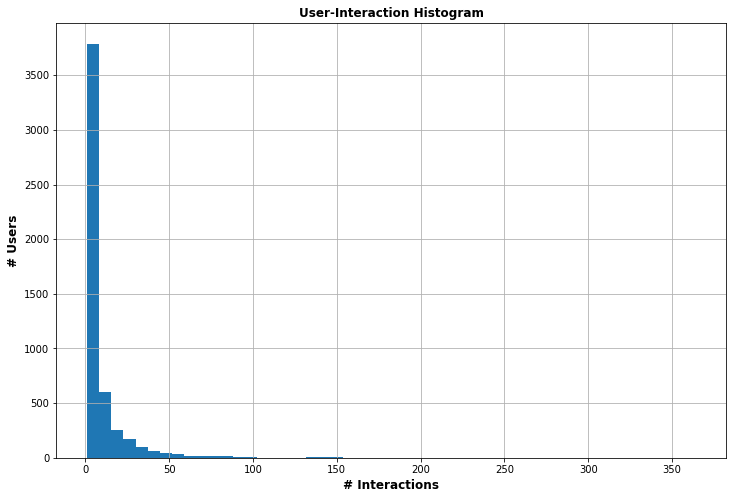

In [9]:
ax = df.groupby(['email']).size().hist(bins=50, figsize=(12,8))

# Set title, labels
ax.set_title('User-Interaction Histogram', fontweight='bold', fontsize=12)
ax.set_xlabel('# Interactions', fontweight='bold', fontsize=12)
ax.set_ylabel('# Users', fontweight='bold', fontsize=12);

It can be seen how the number of interactions is distributed in a fairly narrow way with 75% of the users interacting with less than 10 articles, but with some isolated cases of quite high pikes.

In [10]:
# Storing median/max in variables for later evaluation

# 50% of individuals interact with ____ number of articles or fewer.
median_val = df.groupby(['email']).size().median()  

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = df.groupby(['email']).size().max() 

median_val, max_views_by_user

(3.0, 364)

`Q2.` Explore and remove duplicate articles from the **df_content** dataframe.  

`A2.` For this we can use the pandas [`duplicated`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html) method:

In [11]:
# Find how many duplicates there are
df_content[df_content.duplicated(subset=['article_id']) == True].shape

(5, 5)

It seems we don't have many duplicates; we could actually see directly what they look like:

In [12]:
# Let's take a look at them
df_content[df_content.duplicated(subset=['article_id']) == True].head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


We can take a look at all the entries that can be found for a couple of these articles, to better see what the issue might be:

In [13]:
df_content.query('article_id == 50')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [14]:
df_content.query('article_id == 221')

,doc_body,doc_description,doc_full_name,doc_status,article_id
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221


We can see we have the same id and full name, and in some cases the same body, but we have different description.

In the following, the project's requirements ask to keep only the first entry:

In [15]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content[df_content.duplicated(subset=['article_id'], keep = 'first') == False]

We can look at the size of the dataframe to check that we have removed the 5 duplicated rows:

In [16]:
df_content.shape

(1051, 5)

`Q3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

`A3.`  
**a.** The number of unique articles that have an interaction with a user can be found applying [`nunique`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html) to the `article_id` column of the `df` dataframe:

In [17]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
unique_articles

714

**b.** The number of unique articles in the dataset (regardless of the interactions) can be found using the same method used before, this time on the `df_content` dataframe:

In [18]:
# The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()
total_articles

1051

We can see that there are more than 300 articles that no user has interacted with.

**c.** The not null users can be found using pandas [`notna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.notna.html#pandas.DataFrame.notna):

In [19]:
# The number of unique users
unique_users = df[df.email.notna()].email.nunique()
unique_users

5148

**d.** Finally the total number of user-article interaction is just the size of `df`

In [20]:
# The number of user-article interactions
user_article_interactions = df.shape[0]
user_article_interactions

45993

`Q4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  

**Note**: After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

`A4.` One way to count occurrences of individual items in the `article_id` column is to use pandas [`value_counts`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html). The methods returns Series containing counts of unique values, sorted in descending order:

In [21]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = df.article_id.value_counts().index[0].astype(str)
most_viewed_article_id

'1429.0'

The series returned by `value_counts` has the number of occurrences as an index, hence: 

In [22]:
# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().iloc[0]
max_views

937

Finally, the code in the cell below was provided by the project to map the user email to a user_id

In [23]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [24]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`Q1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [25]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Top article ids - without type conversion
    top_article_ids = df.article_id.value_counts().index[:n].tolist() 
    # Top article titles from df (not df_content), in the same order
    top_articles = []
    for i in range(len(top_article_ids)):
        top_articles.append(df.loc[df['article_id'] == top_article_ids[i]].title.unique()[0])
    
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Return the top article ids
    top_article_ids = df.article_id.value_counts().index[:n].astype(str).tolist() 
    return top_article_ids 

In [26]:
# Take a look at an example:
get_top_articles(7)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization']

In [27]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`Q1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

`A1.` The function below makes use of the pandas [`unstack`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html) funtion. Note that the three statements could actually be concatenated as a single one, and are here shown independently just for clarity.

In [28]:
# Create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Dropping duplicates in user and article id
    df1 = df.drop_duplicates(subset=['article_id', 'user_id'])
    # Grouping the titles per article and user
    df2 = df1.groupby(['article_id', 'user_id']).title.count()
    # Unstacking the previous groups and putting a 0 in empty cells 
    user_item = df2.unstack(level=0, fill_value=0)
    
    return user_item # return the user_item matrix 

In [29]:
# Call the create_user_item_matrix function
user_item = create_user_item_matrix(df)

In [30]:
# Show the user_item matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


Once the test has passed, we can save the matrix as a pickle file fur further reuse in [**Part V**](#Matrix-Fact):

In [32]:
# user_item.to_pickle('./data/user_item_matrix.p')

`Q2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

`A2.` In the following I will show two implementations, on based on the dot product approach and another one using the [cosine similarity](https://www.machinelearningplus.com/nlp/cosine-similarity/). The test at the end of the section seems to expect the first one, so I will keep using it in the following.

Also, I slightly modified the pre-provided template to return not only the list of similar items but also a list with the values of the similarity metric. This will be helpful in the following.

In [33]:
# Implementation using dot product
def find_similar_users_dot(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    similarities - (list) an ordered list where the highest similarities are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    similarity = np.dot(np.array(user_item[user_item.index == user_id]), np.array(user_item).transpose())
    # Create a series with the ids as index
    similarity = pd.Series(similarity.reshape(-1).tolist(), index=user_item.index)
    # Sort from the one with the biggest similarity
    similarity = similarity.sort_values(ascending=False)
    # Separate ids
    most_similar_users = similarity.index.tolist()
    # Remove the own user's id and similarity
    most_similar_users.remove(user_id)
    similarity.drop(labels = user_id, inplace = True)
    # Convert similarities to list
    similarities = similarity.values.tolist()
    
    return most_similar_users, similarities # return a list of the users in order from most to least similar
        

In [34]:
## Implementation using cosine similarity
def find_similar_users_cos(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest cosine similarity)
                    are listed first
    similarities - (list) an ordered list where the highest similarities are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    similarity = cosine_similarity(user_item[user_item.index == user_id], user_item)   
    # Create a series with the ids as index
    similarity = pd.Series(similarity.reshape(-1).tolist(), index=user_item.index)
    # Sort from the one with the biggest similarity
    similarity = similarity.sort_values(ascending=False)
    # Keep only ids
    most_similar_users = similarity.index.tolist()
    # Remove the own user's id and similarity
    most_similar_users.remove(user_id)
    similarity.drop(labels = user_id, inplace = True)
    # Convert similarities to list
    similarities = similarity.values.tolist()
    
    return most_similar_users, similarities # return a list of the users in order from most to least similar
        

In [35]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users_dot(1)[0][:10]))
print("Their similarities are: {}".format(find_similar_users_dot(1)[1][:10]))

print("The 5 most similar users to user 3933 are: {}".format(find_similar_users_dot(3933)[0][:5]))
print("Their similarities are: {}".format(find_similar_users_dot(3933)[1][:5]))

print("The 3 most similar users to user 46 are: {}".format(find_similar_users_dot(46)[0][:3]))
print("Their similarities are: {}".format(find_similar_users_dot(46)[1][:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
Their similarities are: [35, 17, 17, 15, 15, 14, 14, 13, 13, 12]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
Their similarities are: [35, 17, 17, 15, 15]
The 3 most similar users to user 46 are: [4201, 23, 3782]
Their similarities are: [40, 26, 26]


In [36]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users_cos(1)[0][:10]))
fmtL = "Their similarities are: [" + ', '.join(["{:.3f}"]*len(find_similar_users_cos(1)[0][:10])) + "]"
print(fmtL.format(*find_similar_users_cos(1)[1][:10]))

print("The 5 most similar users to user 3933 are: {}".format(find_similar_users_cos(3933)[0][:5]))
fmtL = "Their similarities are: [" + ', '.join(["{:.3f}"]*len(find_similar_users_cos(3933)[0][:5])) + "]"
print(fmtL.format(*find_similar_users_cos(3933)[1][:5]))

print("The 3 most similar users to user 46 are: {}".format(find_similar_users_cos(46)[0][:3]))
fmtL = "Their similarities are: [" + ', '.join(["{:.3f}"]*len(find_similar_users_cos(46)[0][:3])) + "]"
print(fmtL.format(*find_similar_users_cos(46)[1][:3]))

The 10 most similar users to user 1 are: [3933, 4201, 46, 253, 5034, 824, 5041, 136, 2305, 395]
Their similarities are: [0.986, 0.343, 0.343, 0.333, 0.333, 0.333, 0.302, 0.298, 0.298, 0.295]
The 5 most similar users to user 3933 are: [1, 46, 4201, 824, 253]
Their similarities are: [0.986, 0.347, 0.347, 0.338, 0.338]
The 3 most similar users to user 46 are: [4201, 790, 5077]
Their similarities are: [1.000, 0.381, 0.363]


`Q3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

`A3.` Some of the code here is a rivisitation of what was prepared during the lesson:

In [37]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    Description:
    Provides a list of the article titles given a list of article ids
    '''
    # Copy across df
    df_article_idx = df
    # Change type of article_id to be consistent with query
    df_article_idx.article_id = df_article_idx.article_id.astype(str)
    # Drop duplicates and set article_id as index
    df_article_idx = df_article_idx.drop_duplicates(subset='article_id').set_index('article_id')
    # Select rows corrensponding to article_ids and return titles as list
    article_names = df_article_idx.loc[article_ids].title.tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the user_item row for the user_id
    user_row = user_item[user_item.index == user_id]
    # Get the columns where user_row == 1. This are the article_id the user has seen
    article_ids = user_row.columns[(user_row == 1).iloc[0]].astype(str).tolist()
    # Call article_names to get the titles
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # Return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # id_seen by user - to be excluded
    id_seen = get_user_articles(user_id)[0]
    # Similar users to user_id
    similar_users = find_similar_users_dot(user_id)[0]
    
    # Keep the recommended items here
    recs = []
    
    # Go through the similar users and identify items they have seen and user_id has not
    for user in similar_users:
        # Items seen by user
        id_seen_sim_us = get_user_articles(user)[0]
        # Obtain recommendations for each similar user
        new_recs = np.setdiff1d(id_seen_sim_us, id_seen, assume_unique=True).tolist()       
        # Update recs with new recs
        recs = recs + new_recs     
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
    
    # Keep only the first m
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [38]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

`Q4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

`A4.` For the sorting of the users I will reuse the `find_similar_users` function previously definied, keeping both the outputs:

In [40]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Get similar users and their similar values. This is already sorted by similarity
    neighbor_id, neighbor_sim = find_similar_users_dot(user_id, user_item)
    # Get the number of interactions for the neighbors in neighbor_id, as another list
    neighbor_interact = df.groupby(['user_id']).size()[neighbor_id].values.tolist()
    # Build target df
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id,\
                                 'similarity': neighbor_sim,\
                                 'num_interactions': neighbor_interact}).set_index('neighbor_id')
    # Keep sorting with similarity, add num_interactions
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False], inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # id_seen by user - to be excluded
    id_seen = get_user_articles(user_id)[0]
    # Top sorted users similar to user_id
    top_sorted_users = get_top_sorted_users(user_id)
    
    # Keep the recommended items here
    recs = []
    
    # Iterate over top_sorted_users dataframe
    for i, row in top_sorted_users.iterrows():
        # Index
        user = i
        # Items seen by user
        id_seen_sim_us = get_user_articles(user)[0]
        # Obtain recommendations for each similar user
        new_recs = np.setdiff1d(id_seen_sim_us, id_seen, assume_unique=True).tolist()
        
        # Check if we're going to exceed m considering this new_recs
        if (len(recs) + len(new_recs)) > m:
            # We will pick only those that have the highest interactions in general 
            # Get the global number of interactions (across all users) for the new_recs
            global_int_new_recs = []
            for i in range(len(new_recs)):
                global_int_new_recs.append(df[df.article_id == new_recs[i]].shape[0])
            # Sort new recs based on the total number of interactions
            sorted_zipped_recs = sorted(zip(global_int_new_recs, new_recs), reverse = True)
            sorted_new_recs = [element for _, element in sorted_zipped_recs]
            # Update recs with Sorted new recs
            recs = recs + sorted_new_recs
        else:
            # Just pick all the new_recs 
            recs = recs + new_recs
            
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            break
            
    # Keep only the first m
    recs = recs[:m]
    # Get the article names  
    rec_names = get_article_names(recs)
        
    return recs, rec_names

In [41]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`Q5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

`A5.` We can use `get_top_sorted_users` and retrieve just the index of the returned dataframe.

In [42]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).index[0]

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).index[9] 

user1_most_sim, user131_10th_sim

(3933, 242)

In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`Q6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

`A6.` For a new user, collaborative filtering techniques would not work: there will be no information to assess similarity with existing users and their choices.
For this reason the best option amongst the available ones would be **rank based**: new users would see the items that are more popular in absolute sense, i.e. they have the highest number of interactions.

`Q7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

`A7.` As just said, in this case we will use the `get_top_article_ids` function:

In [44]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [45]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (OPTIONAL)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`Q1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

`A1.` As suggested in the text, we can try to implement some form of NLP pipeline that analyzes, for example, the **doc_full_name**. 

**Note**: Some of the code here in the follow is reused from either the specific Udacity class or my previous project on a [Disaster Response Pipeline](https://github.com/russom/DSND-P3-Disaster-Response-Pipeline).

We first define a tokenizer function to be used against the text of the document description: 

In [46]:
# Tokenizer function
def tokenize(text):
    '''
    INPUT:
    text - (str) A text string to process
            
    OUTPUT:
    tokens - (list)  A list of tokens identified in a text string
    rec_arts_titles - (list)  the titles of the m articles that are more similar to article_id
                    
    Description:
    Tokenizer for text strings.
    
    '''
    if len(text) > 0:
        # Normalize case and remove punctuation
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
        # Tokenize text
        tokens_raw = word_tokenize(text)
    
        # Lemmatize and remove stop words
        tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens_raw if (word not in stopwords.words('english'))]
        
    return tokens

Then we build a corpus of the existing descriptions, taking care of handling the non-text or empty use cases:

In [47]:
# Build corpus of descriptions
corpus = []

for i, row in df_content.iterrows():
#     print('Msg = ', i , ' of ', df_content.shape[0])
    if (type(row.doc_description) == str):
        corpus.append(row.doc_full_name)
    else:
        # Typecast when not a NAN
        if (~np.isnan(row.doc_description)):
            corpus.append(row.doc_full_name)
        else:
            print('NAN found at index = ', i)
            # append dummy string - will be filtered by tokenizer
            corpus.append('***')

NAN found at index =  354
NAN found at index =  768
NAN found at index =  919


We can then define a [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to analyze the corpus (making use of our tokenizer) and fit a vocabulary:

In [48]:
# Initialize tf-idf vectorizer object
vectorizer = TfidfVectorizer(tokenizer=tokenize)

# Compute bag of word counts and tf-idf values
TfIdfMat = vectorizer.fit_transform(corpus)

# Convert sparse matrix to numpy array
# Uncomment the next line if you want to view the TfIdfMat 
# TfIdfMat.toarray()

If we want, we can take a look at the vocabulary created:

In [49]:
# Uncomment to look at the vocabulary
# vectorizer.vocabulary_

To get a sense of how many words have we identified:

In [50]:
len(vectorizer.vocabulary_)

1653

We can now use all these elemnts in the recommendation function:

In [51]:
def make_content_recs(article_id, m, df_content=df_content, TfIdfMat=TfIdfMat, vectorizer=vectorizer):
    '''
    INPUT:
    user_id - (int)
    m - (int) the number of recommendations you want for the user
    df_content - (pandas dataframe) df_content as defined at the top of the notebook 
    TfIdfMat - (sparse matrix) Tf-idf-weighted document-term matrix obtained from the corpus of available doc titles
    vectorizer - (object) TfIdf vectorizer, trained on the corpus of available doc titles
            
    OUTPUT:
    rec_arts_id - (list)  the id's of the m articles that are more similar to article_id
    rec_arts_titles - (list)  the titles of the m articles that are more similar to article_id
                    
    Description:
    Returns the id's and titles of m article that are similar the the one identifyied by article_id, 
    starting from the most similar.
    Similarity is defined based on an NLP analysis of the titles, and measured through cosine similarity.
    
    '''
    # Read the doc description for the article_id
    query_str = 'article_id == ' + str(article_id)
    msg = df_content.query(query_str).doc_full_name.values[0]
    
    # Transform the msg according to the vectorizer
    transf_msg = vectorizer.transform([msg])
    
    # Check the similarities between this vector and the other in the TfIdfMat.
    # For this we can use the cosine similarity
    sim_titles = cosine_similarity(transf_msg, TfIdfMat)[0].tolist()
    
    # Get the list of articles
    arts = df_content.article_id.astype(str).tolist()
    
    # Drop from both lists article_id itself
    sim_titles.pop(arts.index(str(article_id)))
    arts.pop(arts.index(str(article_id)))
    
    # Order the articles bsed on the similitude
    sorted_arts = [x for _,x in sorted(zip(sim_titles,arts), reverse=True)]
    
    # Select the first m
    rec_arts_id = sorted_arts[:m]
    
    # Get also titles and descriptions
    rec_arts_titles = []
    rec_arts_desc = []

    for art_id in rec_arts_id:
        query_str = 'article_id == ' + art_id
        rec_arts_titles.append(df_content.query(query_str).doc_full_name.values[0])
    
    return rec_arts_id, rec_arts_titles

`Q2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

`A2.` The approach I followed was (I think) quite straightforward: I went for some NLP processing of the title of the articles to identify those more similar to the one of an article provided as an input.

For sure several improvements are possible: in terms of the analysed content, one could decide to work on the article description, or even full body. This might lead to better results, however has the drawback of leading to bigger vocabularies, that might become heavy in terms of performances.  
Moreover, information on the number on times article have been seen could be used to order articles with the same similarity.  

Finally, another possible evolution could be to get in input a text string from the user rather than an article_id: this would allow the usage of the function also for brand new users, assuming that they provide at least an indication of what they're looking for as a list of keywords.

`Q3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

`A3.` As I explained in the previous answer, the code as it is at the moment cannot be used to provide recommendations for a brand new user.  
However, as soon as somebody has interacted at least once with the platform it would be possible to get a list of recommendation based on the articles' titles.

In [52]:
# make recommendations for a brand new user
# This is not possible with the current code

In [53]:
# make a recommendations for a user who only has interacted with a given article
rec_arts_id, rec_arts_titles = make_content_recs(235, 5)
print('Reference article title: ', df_content.query('article_id == 235').doc_full_name.values[0])
print('Id if the 5 most similar articles :', rec_arts_id)
print('Titles if the 5 most similar articles :', rec_arts_titles)

Reference article title:  How to enable a Redis cache for PostgreSQL with Entity Framework 6
Id if the 5 most similar articles : ['689', '537', '627', '420', '811']
Titles if the 5 most similar articles : ['Improved Performance for Redis Cache Mode on Compose', 'Compose PostgreSQL powers up to 9.6', 'Importing Redis data into Compose Redis', 'CACHE Table in Apache Spark SQL', 'Getting the distance using Redis and PostgreSQL']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`Q1.` You should have already created a **user_item** matrix above in **question 1** of [**Part III**](#User-User) above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

`A1`. We can either use the matrix that we've just calculated, or load it from the pickle file we created:

In [54]:
# Option 1: Use the matrix calculated in the cells above, renaming it to be used by the subsequent functions
user_item_matrix = user_item
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Option 2: Load the matrix from a pikle file
# user_item_matrix = pd.read_pickle('./data/user_item_matrix.p')
# user_item_matrix.head()

`Q2.` In this situation, you can use Singular Value Decomposition from [numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

`A2.` The fundamental difference with the lesson is that, in this case, the `user_item` matrix is actually **full**. Even though most of it is composed by 0's, _there are no missing values_, hence the closed form expression for the SVD decomposition can be used. 

In [56]:
# Perform SVD on the User-Item Matrix using the built-in function to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices = False)
s.shape, u.shape, vt.shape

((714,), (5149, 714), (714, 714))

`Q3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

`A3.` Here I just split the calculation and plotting of resuts for convenience:

In [57]:
# Calculate estimation errors with increasing number of latent features
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

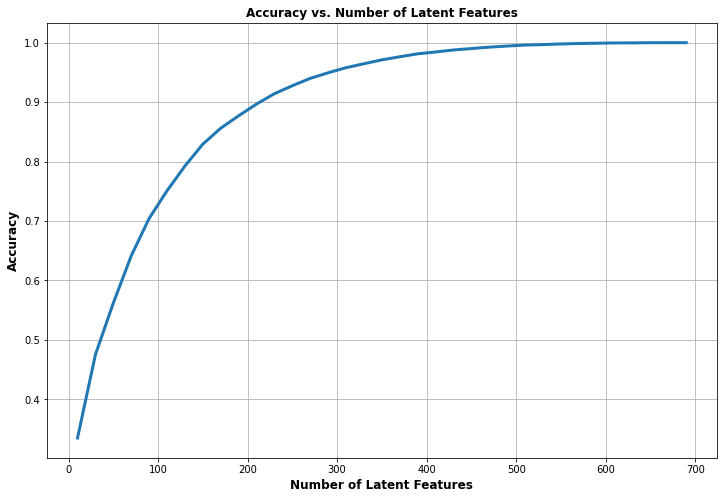

In [58]:
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0], linewidth = 3);
plt.xlabel('Number of Latent Features', fontweight='bold', fontsize=12);
plt.ylabel('Accuracy', fontweight='bold', fontsize=12);
plt.title('Accuracy vs. Number of Latent Features', fontweight='bold', fontsize=12);
plt.grid()

`Q4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

`A4.` We already wrote a function to create a proper `user_item` matrix in previous cells; we are just going to reuse it here in the following:

In [59]:
# Split train/test
df_train = df.head(40000)
df_test = df.tail(5993)

In [60]:
# Implement function to extract matrices and vectors of features
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # First of all, we calculate the 2 user_item matrices:
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Then we extract the index and columns for user_item_test
    test_idx = user_item_test.index.values.tolist()
    test_arts = user_item_test.columns.values.tolist()
    
    # We also extract the same lists for user_item_train
    train_idx = user_item_train.index.values.tolist()
    train_arts = user_item_train.columns.values.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts

In [61]:
# Call function
user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts = \
    create_test_and_train_user_item(df_train, df_test)

In [62]:
# Check outputs
print('Shape of the training user-item matrix = ', user_item_train.shape)
print('Shape of the test user-item matrix = ', user_item_test.shape)
print()
print('Num. of users that are common between test and train dataset = ', len(set(train_idx).intersection(test_idx)))
print('Num. of users that are present only in the test dataset = ', len(test_idx) - \
      len(set(train_idx).intersection(test_idx)))
print()
print('Num. of articles that are common between test and train dataset = ', len(set(train_arts).intersection(test_arts)))
print('Num. of articles that are present only in the test dataset = ', len(test_arts) - \
      len(set(train_arts).intersection(test_arts)))

Shape of the training user-item matrix =  (4487, 714)
Shape of the test user-item matrix =  (682, 574)

Num. of users that are common between test and train dataset =  20
Num. of users that are present only in the test dataset =  662

Num. of articles that are common between test and train dataset =  574
Num. of articles that are present only in the test dataset =  0


In [63]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`Q5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

`A5`. The key for the nex step will be to calculate the SVD for the train dataset and then select the items (user_id's and articles) that have a correnspondence in the test dataset, so to compare the output of the SVD for various different numbers of features against the test data.

In [64]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices = False)
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 714), (714, 714))

In [65]:
# Find the indices in the train and test datasets that correnspond to the common users
# Note: these are the 0 based indices, to use them also on the numpy array
common_users = set(train_idx).intersection(test_idx)
common_indices_id_train = []
common_indices_id_test = []


for common_element in common_users:
    common_indices_id_train.append(train_idx.index(common_element))
    common_indices_id_test.append(test_idx.index(common_element))
    
common_indices_id_train  = sorted(common_indices_id_train)
common_indices_id_test = sorted(common_indices_id_test)

In [66]:
# Find the indices in the train and test datasets that correnspond to the common articles
# Note: these are the 0 based indices, to use them also on the numpy array
common_arts = set(train_arts).intersection(test_arts)
common_indices_art_train = []
common_indices_art_test = []


for common_element in common_arts:
    common_indices_art_train.append(train_arts.index(common_element))
    common_indices_art_test.append(test_arts.index(common_element))
    
common_indices_art_train  = sorted(common_indices_art_train)
common_indices_art_test = sorted(common_indices_art_test)

In [67]:
# Select the subsets of the training and test user_item matrices that correnspond to the common users
us_it_train_sub = user_item_train.iloc[common_indices_id_train]
us_it_test_sub = user_item_test.iloc[common_indices_id_test]

In [68]:
# Select also the common columns between training and testing
us_it_train_sub = us_it_train_sub[test_arts]

In [69]:
# Take a look at the reduced user_item matrix for training data
us_it_train_sub.head()

article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [70]:
# Take a look at the reduced user_item matrix for test data
us_it_test_sub.head()

article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Select the rows in u_train that are associated with the common users
u_train_sub = u_train[common_indices_id_train, :]
u_train_sub.shape

(20, 714)

In [72]:
# Select the coulmns in vt_train that are associated with the common articles
vt_train_sub = vt_train[:, common_indices_art_train]
vt_train_sub.shape

(714, 574)

Now we can reuse the code used previously for the accuracy of the prediction, but checking the result of the SVD calculation against the _test_ dataframe. For comparison, we will keep track of the accuracy of prediction againt the _training_ dataset also.

Besides checking the results in terms of accuracy, I will also keep track of the MSE, here too against both test and training dataset.

In [73]:
# Calculate estimation errors with increasing number of latent features
num_latent_feats = np.arange(10,700+10,20)
sum_errs_test = []
sum_errs_train = []
mse_train = []
mse_test = []

# Number of non-null user_item pairs. This is the same for both training and testing
num_pairs = np.count_nonzero(~np.isnan(us_it_test_sub))
    
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train_sub[:, :k], vt_train_sub[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs_test = np.subtract(us_it_test_sub, user_item_est)
    diffs_train = np.subtract(us_it_train_sub, user_item_est)
    
    # total errors and keep track of them
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sse_test =  np.sum(np.sum(np.square(diffs_test)))
    sse_train =  np.sum(np.sum(np.square(diffs_train)))
    
    sum_errs_test.append(err_test)
    sum_errs_train.append(err_train)
    mse_test.append(sse_test/num_pairs)
    mse_train.append(sse_train/num_pairs)

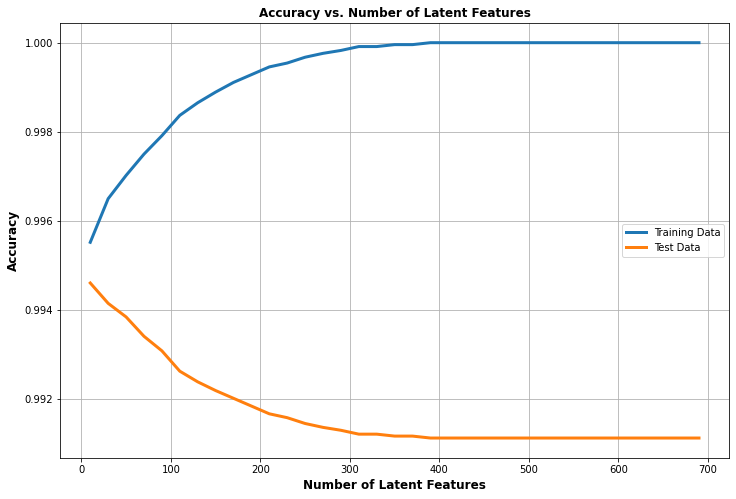

In [74]:
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], linewidth = 3);
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], linewidth = 3);
plt.xlabel('Number of Latent Features', fontweight='bold', fontsize=12);
plt.ylabel('Accuracy', fontweight='bold', fontsize=12);
plt.title('Accuracy vs. Number of Latent Features', fontweight='bold', fontsize=12);
plt.legend(['Training Data', 'Test Data'],fontsize=10, loc='center right')
plt.grid()

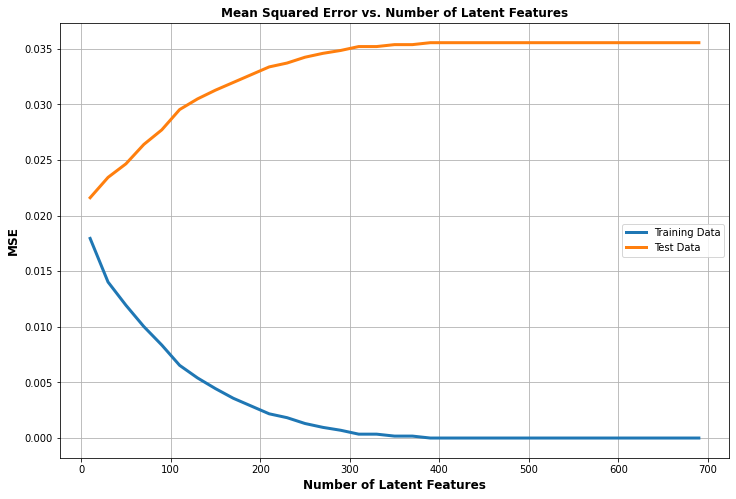

In [75]:
# Plot results
plt.figure(figsize=(12, 8))
plt.plot(num_latent_feats, mse_train, linewidth = 3);
plt.plot(num_latent_feats, mse_test, linewidth = 3);
plt.xlabel('Number of Latent Features', fontweight='bold', fontsize=12);
plt.ylabel('MSE', fontweight='bold', fontsize=12);
plt.title('Mean Squared Error vs. Number of Latent Features', fontweight='bold', fontsize=12);
plt.legend(['Training Data', 'Test Data'],fontsize=10, loc='center right')
plt.grid()

`Q6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

`A6.` From the results above it would seem that there is not much value in increasing the number of latent features beyond a minimum (in this case = 10).

For what concerns the training data, obviosly the results of the SVD decomposition tend to be exact as the number of features increases, but even at the minimum we have an accuracy of more than 90%.  
On the other hand, for the test datasets the results actually _worsen_ as the number of feature increases (both in terms of accuracy and MSE), suggesting some kind of "overfitting" behaviour.

In any case, it should be noted how the actual size of the dataset used for this analysis is fairly small, with only 20 users available to compare a prediction with an actual result.  
As an example of better represetation, if we look at the SVD decomposition results for the full user/item matrix we can see how the effect of the number of features is musch more evident, and how we need to consider at least 200 features to have an accuracy > 90%.

The point above applies as a general concept to all the recommendation engines: to properly evaluate a prediction strategy we would need either more data or a better distribution of user between training and test datasets.